In [ ]:
#manage imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
#import google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#read data (post data cleaning)
data = pd.read_csv("/content/drive/My Drive/DAT490 Team Folder/output.csv")

/tmp/ipython-input-986447875.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/drive/My Drive/DAT490 Team Folder/output.csv")


In [ ]:
#get current shape
data.shape

(934714, 22)

In [ ]:
#pull head for column reference
data.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,...,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2
0,11/01/2023,1:29,BROOKLYN,11230.0,40.621790,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,1.0,...,0,0,0,1,0,Unspecified,Unspecified,4675373,Moped,Sedan
1,12/14/2021,14:58,MANHATTAN,10017.0,40.751440,-73.973970,"(40.75144, -73.97397)",3 AVENUE,EAST 43 STREET,0.0,...,0,0,0,0,0,Passing Too Closely,Unspecified,4486519,Sedan,Station Wagon/Sport Utility Vehicle
2,12/14/2021,16:50,QUEENS,11413.0,40.675884,-73.755770,"(40.675884, -73.75577)",SPRINGFIELD BOULEVARD,EAST GATE PLAZA,0.0,...,0,0,0,0,0,Turning Improperly,Unspecified,4487127,Sedan,Station Wagon/Sport Utility Vehicle
3,12/14/2021,23:10,QUEENS,11434.0,40.666840,-73.789410,"(40.66684, -73.78941)",NORTH CONDUIT AVENUE,150 STREET,2.0,...,0,0,0,2,0,Reaction to Uninvolved Vehicle,Unspecified,4486635,Sedan,Sedan
4,12/11/2021,19:43,BRONX,10463.0,40.872620,-73.904686,"(40.87262, -73.904686)",WEST KINGSBRIDGE ROAD,HEATH AVENUE,1.0,...,0,0,0,1,0,Unspecified,Unspecified,4487040,Station Wagon/Sport Utility Vehicle,Sedan


In [ ]:
#find top values for specific columns
data['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().sort_values(ascending=False).head(20)
data['VEHICLE TYPE CODE 1'].value_counts().sort_values(ascending=False).head(20)


,count
VEHICLE TYPE CODE 1,
PASSENGER VEHICLE,271906
Sedan,194372
Station Wagon/Sport Utility Vehicle,146848
SPORT UTILITY / STATION WAGON,116691
TAXI,24429
Taxi,19351
VAN,17455
OTHER,15486
Pick-up Truck,11435


In [ ]:
#data cleaning and feature engeneering

#fix vehicle type rows where values are similar
data.loc[data['VEHICLE TYPE CODE 1'].isin(['Station Wagon/Sport Utility Vehicle', 'SPORT UTILITY / STATION WAGON']), 'VEHICLE TYPE CODE 1'] = 'SUV'
data.loc[data['VEHICLE TYPE CODE 1'].isin(['TAXI', 'Taxi']), 'VEHICLE TYPE CODE 1'] = 'Taxi'
data.loc[data['VEHICLE TYPE CODE 1'].isin(['Sedan', '4 dr sedan']), 'VEHICLE TYPE CODE 1'] = 'Sedan'
data.loc[data['VEHICLE TYPE CODE 1'].isin(['Pick-up Truck', 'PICK-UP TRUCK']), 'VEHICLE TYPE CODE 1'] = 'Truck'
data.loc[data['VEHICLE TYPE CODE 1'].isin(['BUS', 'Bus']), 'VEHICLE TYPE CODE 1'] = 'Bus'
data.loc[data['VEHICLE TYPE CODE 1'].isin(['OTHER', 'UNKNOWN']), 'VEHICLE TYPE CODE 1'] = 'Other'
data.loc[data['VEHICLE TYPE CODE 1'].isin(['VAN', 'Van']), 'VEHICLE TYPE CODE 1'] = 'Van'
data.loc[data['VEHICLE TYPE CODE 1'].isin(['MOTORCYCLE', 'Motorcycle']), 'VEHICLE TYPE CODE 1'] = 'Motorcycle'
#data['VEHICLE TYPE CODE 1'].value_counts().sort_values(ascending=False).head(20)

#drop ambiguous values
drop_values = ['Unspecified','Other']
data = data[~data['CONTRIBUTING FACTOR VEHICLE 1'].isin(drop_values)]
data = data[~data['VEHICLE TYPE CODE 1'].isin(drop_values)]

#make binary column for person deaths
data['PERSON_DEATHS'] = np.where(data['NUMBER OF PERSONS KILLED'] > 0, 1, 0)
death_data = data[data['NUMBER OF PERSONS KILLED'] > 0]

#make binary column for person injuries
data['PERSON_INJURIES'] = np.where(data['NUMBER OF PERSONS INJURED'] > 0, 1, 0)
injury_data = data[data['NUMBER OF PERSONS INJURED'] > 0]


#trim vehicle factor 1 rows to only include top 10 values where PERSON_DEATH is true
# Find the top 10 most frequent values
cf_top_10 = death_data['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().nlargest(10).index

# Keep only rows where the column’s value is in the top 10
cf_data = data[data['CONTRIBUTING FACTOR VEHICLE 1'].isin(cf_top_10)]

#cf_data.head()
#cf_data['CONTRIBUTING FACTOR VEHICLE 1'].value_counts()

#keep only top 10 vehicle types where PERSON_DEATHS is true
vt_top_10 = death_data['VEHICLE TYPE CODE 1'].value_counts().nlargest(10).index
vt_data = cf_data[cf_data['VEHICLE TYPE CODE 1'].isin(vt_top_10)]
vt_data.shape

#rename dataframe
data = vt_data
data.shape

#check borough for completness
#vt_data['BOROUGH'].value_counts()


(336846, 24)

In [ ]:
#get what percentage of indicents result in death by top 10 contributing factors and vehicle types
death_data = data[data['PERSON_DEATHS'] == 1]
cf_counts = death_data['CONTRIBUTING FACTOR VEHICLE 1'].value_counts()
vt_counts = death_data['VEHICLE TYPE CODE 1'].value_counts()

cf_percentages = cf_counts / cf_counts.sum() * 100
vt_percentages = vt_counts / vt_counts.sum() * 100

print("Contributing Factor Percentages:")
print(cf_percentages)

print("\nVehicle Type Percentages:")
print(vt_percentages)




Contributing Factor Percentages:
CONTRIBUTING FACTOR VEHICLE 1
Traffic Control Disregarded                              29.203540
Unsafe Speed                                             20.353982
Driver Inattention/Distraction                           14.380531
Failure to Yield Right-of-Way                            12.168142
Alcohol Involvement                                       6.637168
Physical Disability                                       4.424779
Passing or Lane Usage Improper                            3.761062
Driver Inexperience                                       3.539823
Pedestrian/Bicyclist/Other Pedestrian Error/Confusion     3.097345
Following Too Closely                                     2.433628
Name: count, dtype: float64

Vehicle Type Percentages:
VEHICLE TYPE CODE 1
SUV                  28.761062
Sedan                26.769912
Motorcycle           16.592920
PASSENGER VEHICLE    14.380531
Box Truck             2.654867
Bike                  2.433628
Bus   

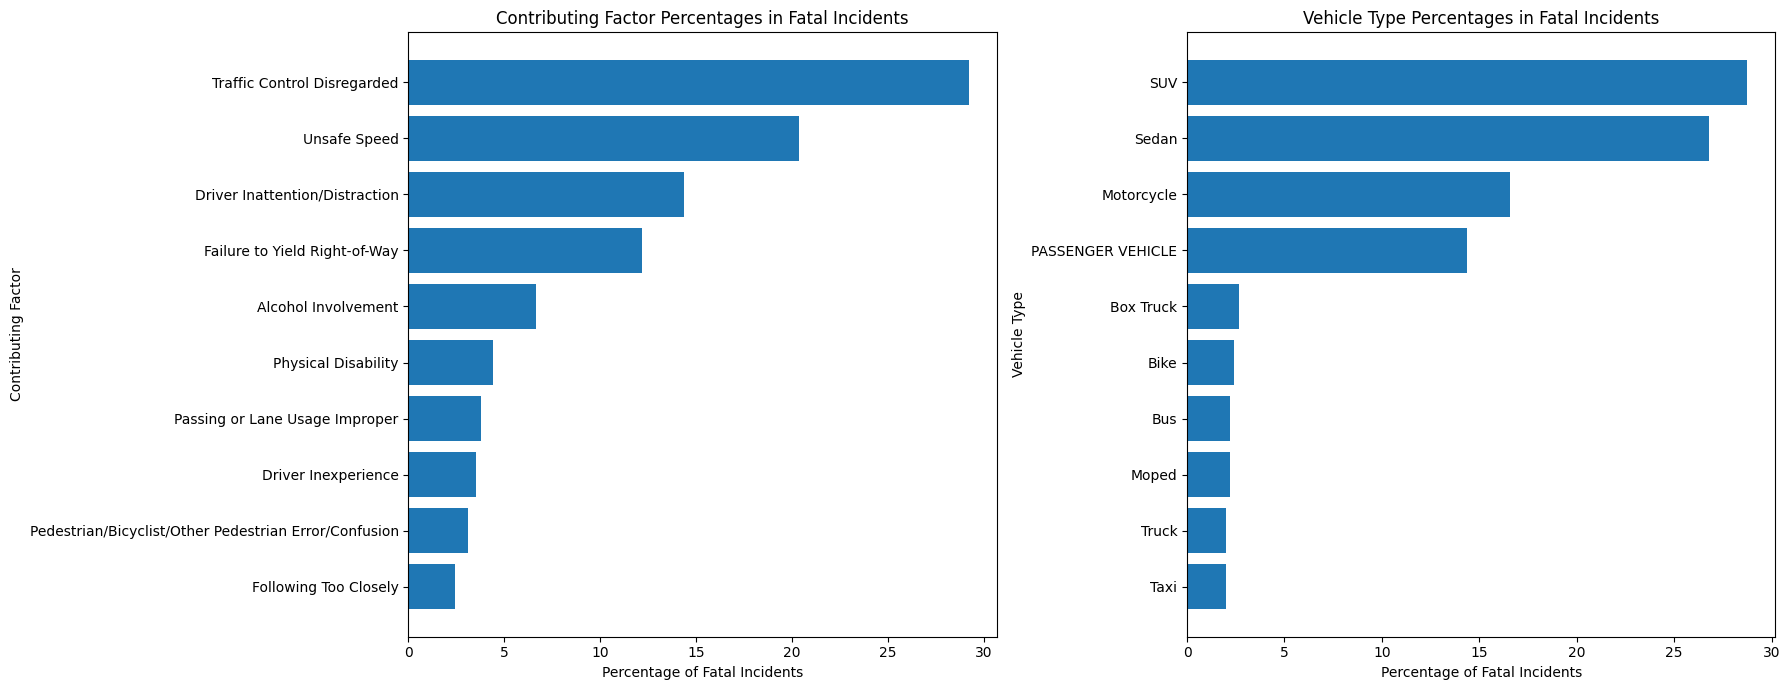

In [ ]:
import matplotlib.pyplot as plt

# Sort the percentages from largest to smallest
cf_percentages_sorted = cf_percentages.sort_values(ascending=False)
vt_percentages_sorted = vt_percentages.sort_values(ascending=False)

fig, axs = plt.subplots(1, 2, figsize=(18, 7)) # Increased figure size

# Plot for Contributing Factor Percentages
axs[0].barh(cf_percentages_sorted.index[::-1], cf_percentages_sorted.values[::-1])
axs[0].set_title("Contributing Factor Percentages in Fatal Incidents")
axs[0].set_ylabel("Contributing Factor")
axs[0].set_xlabel("Percentage of Fatal Incidents")
axs[0].tick_params(axis='y', rotation=0)

# Plot for Vehicle Type Percentages
axs[1].barh(vt_percentages_sorted.index[::-1], vt_percentages_sorted.values[::-1])
axs[1].set_title("Vehicle Type Percentages in Fatal Incidents")
axs[1].set_ylabel("Vehicle Type")
axs[1].set_xlabel("Percentage of Fatal Incidents")
axs[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

#it would be cool if we could weight vehicle type with total vehicles in NYC by type

Contributing Factor Death Percentages:
CONTRIBUTING FACTOR VEHICLE 1
Unsafe Speed                                             0.974163
Traffic Control Disregarded                              0.602767
Pedestrian/Bicyclist/Other Pedestrian Error/Confusion    0.433974
Alcohol Involvement                                      0.311074
Physical Disability                                      0.305951
Driver Inexperience                                      0.118659
Failure to Yield Right-of-Way                            0.093496
Passing or Lane Usage Improper                           0.085264
Driver Inattention/Distraction                           0.040266
Following Too Closely                                    0.033930
Name: count, dtype: float64

Vehicle Type Death Percentages:
VEHICLE TYPE CODE 1
Motorcycle           3.459410
Moped                1.555210
Bike                 0.342359
Box Truck            0.298954
Bus                  0.155788
Truck                0.116565
SUV       

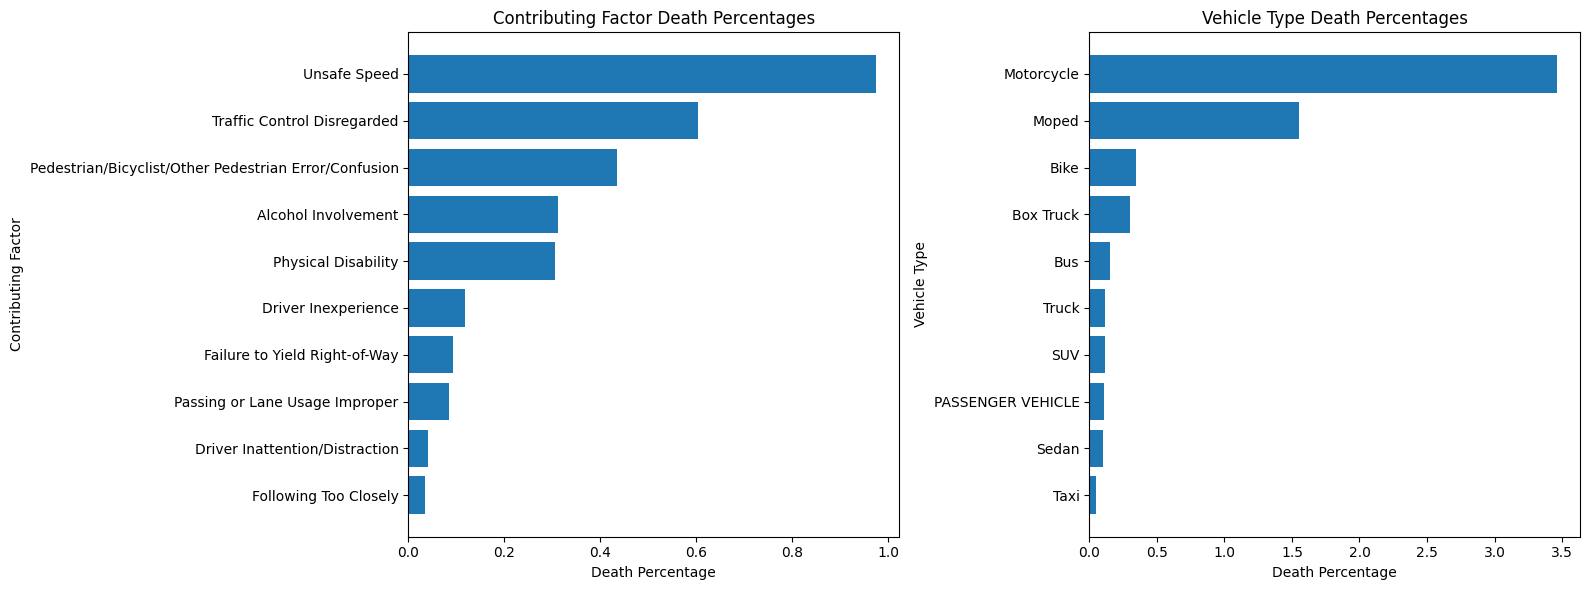

In [ ]:
import matplotlib.pyplot as plt

#get the values of death/total incidents for each contributing factor and vehicle type
cf_death_counts = death_data['CONTRIBUTING FACTOR VEHICLE 1'].value_counts()
vt_death_counts = death_data['VEHICLE TYPE CODE 1'].value_counts()

cf_total_counts = data['CONTRIBUTING FACTOR VEHICLE 1'].value_counts()
vt_total_counts = data['VEHICLE TYPE CODE 1'].value_counts()

cf_death_percentages = (cf_death_counts / cf_total_counts * 100).sort_values(ascending=False)
vt_death_percentages = (vt_death_counts / vt_total_counts * 100).sort_values(ascending=False)

print("Contributing Factor Death Percentages:")
print(cf_death_percentages)

print("\nVehicle Type Death Percentages:")
print(vt_death_percentages)

#plot a bar chart of death percentages
fig, axs = plt.subplots(1, 2, figsize=(16, 6)) # Increased figure size for better readability

axs[0].barh(cf_death_percentages.index[::-1], cf_death_percentages.values[::-1]) # Changed to barh and reversed for top-to-bottom largest
axs[0].set_title("Contributing Factor Death Percentages")
axs[0].set_ylabel("Contributing Factor") # Swapped x and y labels
axs[0].set_xlabel("Death Percentage") # Swapped x and y labels
axs[0].tick_params(axis='y', rotation=0) # Adjusted rotation for y-axis labels

axs[1].barh(vt_death_percentages.index[::-1], vt_death_percentages.values[::-1]) # Changed to barh and reversed for top-to-bottom largest
axs[1].set_title("Vehicle Type Death Percentages")
axs[1].set_ylabel("Vehicle Type") # Swapped x and y labels
axs[1].set_xlabel("Death Percentage") # Swapped x and y labels
axs[1].tick_params(axis='y', rotation=0) # Adjusted rotation for y-axis labels

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
#one-hot encode categorical columns
data = pd.get_dummies(data, columns=['PERSON_INJURIES','PERSON_DEATHS','VEHICLE TYPE CODE 1', 'CONTRIBUTING FACTOR VEHICLE 1', 'BOROUGH'])
data.shape

(336846, 48)

In [ ]:
print("Data types:\n", data.dtypes)

Data types:
 CRASH DATE                                                                              object
CRASH TIME                                                                              object
ZIP CODE                                                                                object
LATITUDE                                                                               float64
LONGITUDE                                                                              float64
LOCATION                                                                                object
ON STREET NAME                                                                          object
CROSS STREET NAME                                                                       object
NUMBER OF PERSONS INJURED                                                              float64
NUMBER OF PERSONS KILLED                                                               float64
NUMBER OF PEDESTRIANS INJURED        

In [ ]:
bool_columns = data.select_dtypes(include='bool').columns

print("Total Counts for Boolean Columns:")
for col in bool_columns:
    print(f"\n{col}:")
    print(data[col].value_counts())


Total Counts for Boolean Columns:

PERSON_INJURIES_0:
PERSON_INJURIES_0
True     241114
False     95732
Name: count, dtype: int64

PERSON_INJURIES_1:
PERSON_INJURIES_1
False    241114
True      95732
Name: count, dtype: int64

PERSON_DEATHS_0:
PERSON_DEATHS_0
True     336394
False       452
Name: count, dtype: int64

PERSON_DEATHS_1:
PERSON_DEATHS_1
False    336394
True        452
Name: count, dtype: int64

VEHICLE TYPE CODE 1_Bike:
VEHICLE TYPE CODE 1_Bike
False    333633
True       3213
Name: count, dtype: int64

VEHICLE TYPE CODE 1_Box Truck:
VEHICLE TYPE CODE 1_Box Truck
False    332832
True       4014
Name: count, dtype: int64

VEHICLE TYPE CODE 1_Bus:
VEHICLE TYPE CODE 1_Bus
False    330427
True       6419
Name: count, dtype: int64

VEHICLE TYPE CODE 1_Moped:
VEHICLE TYPE CODE 1_Moped
False    336203
True        643
Name: count, dtype: int64

VEHICLE TYPE CODE 1_Motorcycle:
VEHICLE TYPE CODE 1_Motorcycle
False    334678
True       2168
Name: count, dtype: int64

VEHICLE TYPE CODE

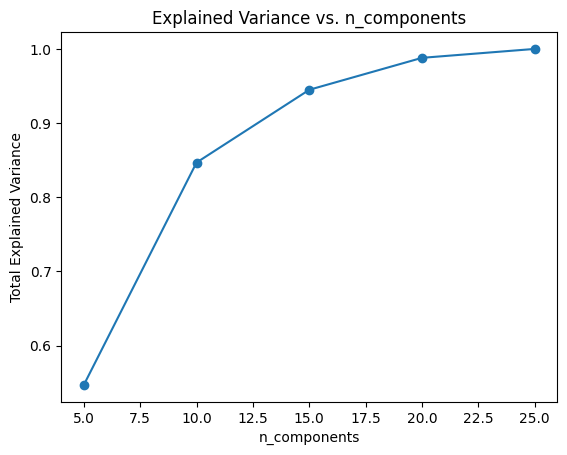

{5: np.float64(0.547), 10: np.float64(0.847), 15: np.float64(0.945), 20: np.float64(0.988), 25: np.float64(1.0)}


In [ ]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from scipy import sparse

X_bool = data.select_dtypes(include=['bool']).astype(int)
X_sparse = sparse.csr_matrix(X_bool.values)

# Try a few n_components values
n_vals = [ 5, 10, 15, 20, 25]
explained = []

for n in n_vals:
    svd = TruncatedSVD(n_components=n, random_state=42)
    svd.fit(X_sparse)
    explained.append(svd.explained_variance_ratio_.sum())

plt.plot(n_vals, explained, marker='o')
plt.title("Explained Variance vs. n_components")
plt.xlabel("n_components")
plt.ylabel("Total Explained Variance")
plt.show()

print(dict(zip(n_vals, [round(e,3) for e in explained])))


k=2: inertia=745199.86, davies_bouldin_score=3.011, calinski_harabasz_score=36269.941
k=3: inertia=669715.48, davies_bouldin_score=2.469, calinski_harabasz_score=39782.807
k=4: inertia=620423.90, davies_bouldin_score=2.244, calinski_harabasz_score=37089.942
k=5: inertia=538191.48, davies_bouldin_score=1.930, calinski_harabasz_score=44952.803
k=6: inertia=514674.90, davies_bouldin_score=2.195, calinski_harabasz_score=40672.898
k=7: inertia=498298.67, davies_bouldin_score=2.164, calinski_harabasz_score=36848.739
k=8: inertia=483807.28, davies_bouldin_score=2.081, calinski_harabasz_score=33971.578
k=9: inertia=459151.92, davies_bouldin_score=1.980, calinski_harabasz_score=33594.395
k=10: inertia=440330.02, davies_bouldin_score=1.945, calinski_harabasz_score=32793.167


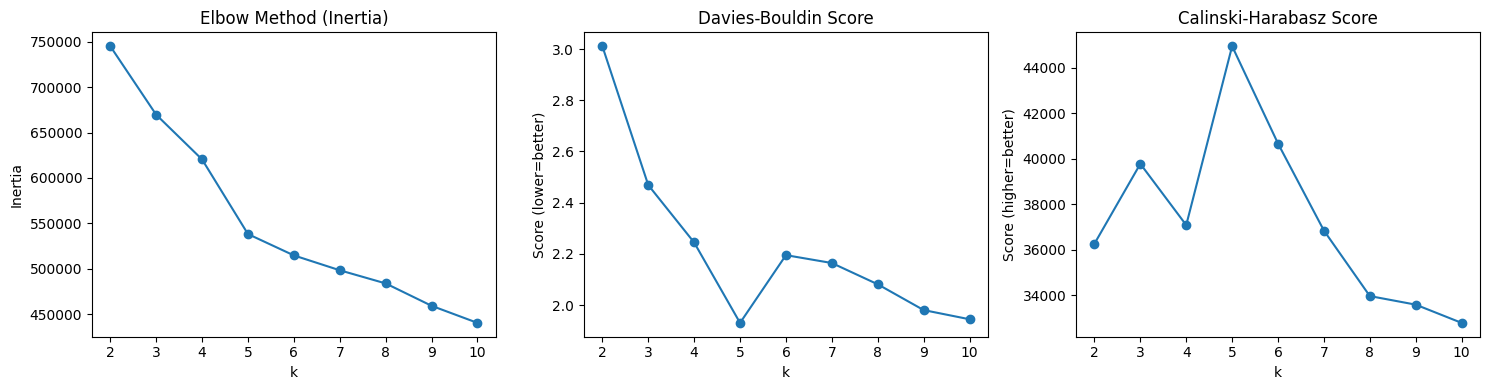

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

# --- reduce dimensionality (PCA-like) ---
n_components = 15                        # tune: 5-30 typically
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_reduced = svd.fit_transform(X_sparse)   # shape: (n_samples, n_components)

ks = range(2, 11)
inertias = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

for k in ks:
    mbk = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=8192)
    labels = mbk.fit_predict(X_reduced)
    inertias.append(mbk.inertia_)
    davies_bouldin_scores.append(davies_bouldin_score(X_reduced, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_reduced, labels))
    print(f"k={k}: inertia={mbk.inertia_:.2f}, davies_bouldin_score={davies_bouldin_scores[-1]:.3f}, calinski_harabasz_score={calinski_harabasz_scores[-1]:.3f}")

# Plot elbow & metrics

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(ks, inertias, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("k"); plt.ylabel("Inertia")

plt.subplot(1,3,2)
plt.plot(ks, davies_bouldin_scores, marker='o')
plt.title("Davies-Bouldin Score")
plt.xlabel("k"); plt.ylabel("Score (lower=better)")

plt.subplot(1,3,3)
plt.plot(ks, calinski_harabasz_scores, marker='o')
plt.title("Calinski-Harabasz Score")
plt.xlabel("k"); plt.ylabel("Score (higher=better)")
plt.tight_layout()

plt.show()

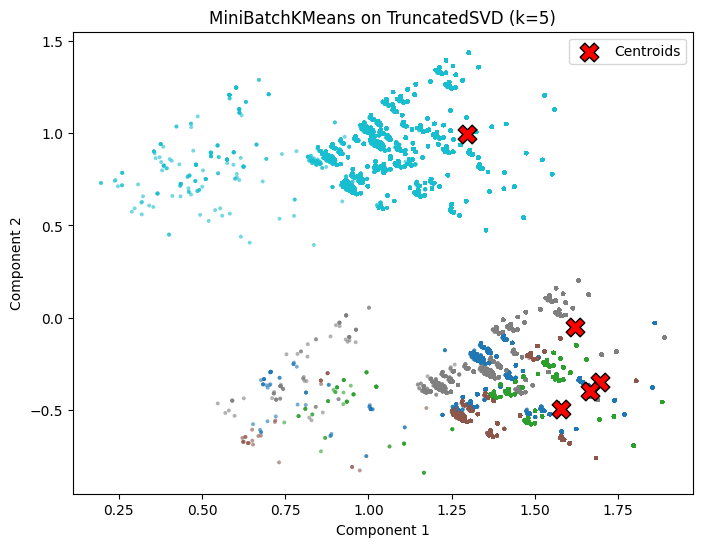

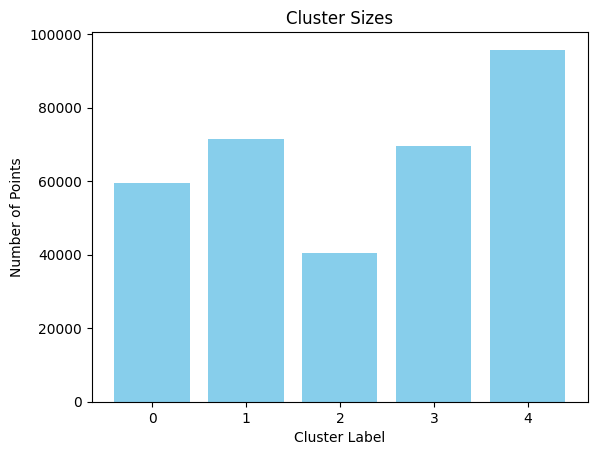

In [ ]:
# Minimal pipeline: TruncatedSVD (PCA-like) -> MiniBatchKMeans -> 2D plot
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans


# --- cluster on reduced features ---
k = 5                                    # choose your k
mbk = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=8192)
labels = mbk.fit_predict(X_reduced)
centers = mbk.cluster_centers_            # in reduced (SVD) space

unique, counts = np.unique(labels, return_counts=True)

# --- quick 2D plot using first 2 SVD components ---
X_plot = X_reduced[:, :2]
centers_plot = centers[:, :2]

plt.figure(figsize=(8,6))
plt.scatter(X_plot[:,0], X_plot[:,1], c=labels, s=8, alpha=0.6, cmap='tab10', linewidths=0)
plt.scatter(centers_plot[:,0], centers_plot[:,1], s=180, c='red', marker='X', label='Centroids', edgecolors='k')
plt.title(f"MiniBatchKMeans on TruncatedSVD (k={k})")
plt.xlabel("Component 1"); plt.ylabel("Component 2")
plt.legend()
plt.show()


plt.bar(range(len(counts)), counts, color='skyblue')
plt.title("Cluster Sizes")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Points")
plt.show()

In [ ]:
feature_names = X_bool.columns
centroids_df = pd.DataFrame(centers, columns=[f"SVD_{i+1}" for i in range(centers.shape[1])])

# If you reduced dimensionality (using TruncatedSVD), those columns are not original features,
# so you’ll need to transform back to feature space like this:
###
svd_components = svd.components_   # shape: (n_components, n_original_features)
centroids_original = np.dot(centers, svd_components)  # back-project to original features
centroids_original_df = pd.DataFrame(centroids_original, columns=feature_names)

# --- show top features for each cluster ---
n_top = 5  # top 10 features per cluster
for i in range(centroids_original_df.shape[0]):
    print(f"\nCluster {i} — Top {n_top} features:")
    top_features = centroids_original_df.iloc[i].sort_values(ascending=False).head(n_top)
    print(top_features)


Cluster 0 — Top 5 features:
PERSON_DEATHS_0                                                 0.998689
PERSON_INJURIES_0                                               0.998257
CONTRIBUTING FACTOR VEHICLE 1_Driver Inattention/Distraction    0.794149
BOROUGH_BROOKLYN                                                0.679873
VEHICLE TYPE CODE 1_PASSENGER VEHICLE                           0.512810
Name: 0, dtype: float64

Cluster 1 — Top 5 features:
PERSON_DEATHS_0                                                 1.001024
VEHICLE TYPE CODE 1_SUV                                         0.996587
PERSON_INJURIES_0                                               0.989352
BOROUGH_QUEENS                                                  0.428459
CONTRIBUTING FACTOR VEHICLE 1_Driver Inattention/Distraction    0.418099
Name: 1, dtype: float64

Cluster 2 — Top 5 features:
PERSON_DEATHS_0                                                 0.999274
PERSON_INJURIES_0                                             

In [ ]:
X = data.select_dtypes(include=['bool']).astype(int)
y = data['PERSON_DEATHS']

#split data to test model, full dataset takes too long to run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional: drop rows with missing values
X = X_train

# Standardize the data
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Choose number of clusters (you can test several)
#ks = range(3, 6)
#inertias = []
#silhouettes = []

#for k in ks:
#    kmeans = KMeans(
#        n_clusters=k,
#        init='k-means++',
#        n_init=10,
#        max_iter=100,
#        random_state=42
#    )
#    labels = kmeans.fit_predict(X)
#    inertias.append(kmeans.inertia_)
#    silhouettes.append(silhouette_score(X, labels))
#    print(f"k={k} done")
#print('finished loop')
# Plot elbow and silhouette
#fig, ax = plt.subplots(1, 2, figsize=(12, 4))
#ax[0].plot(ks, inertias, marker='o')
#ax[0].set_title("Elbow: Inertia vs k")
#ax[0].set_xlabel("k"); ax[0].set_ylabel("Inertia")

#ax[1].plot(ks, silhouettes, marker='o')
#ax[1].set_title("Silhouette Score vs k")
#ax[1].set_xlabel("k"); ax[1].set_ylabel("Silhouette")
#plt.show()

# Choose best k (max silhouette)
#best_k = ks[int(np.argmax(silhouettes))]
#print("Best k:", best_k)
best_k = 4
# Final model
kmeans = KMeans(
    n_clusters=best_k,
    init='k-means++',
    n_init='auto',
    random_state=42
)
labels = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

# Visualize clusters with PCA (2D)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
centroids_pca = pca.transform(centroids)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=40, alpha=0.7, cmap='tab10')
plt.scatter(centroids_pca[:,0], centroids_pca[:,1],
            s=250, c='red', marker='X', label='Centroids')
plt.title(f"K-Means++ (k={best_k}) — PCA projection")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.show()


KeyError: 'PERSON_DEATHS'